## Triplet Loss Learning on FashionMNIST data.

inspired by https://medium.com/@enoshshr/triplet-loss-and-siamese-neural-networks-5d363fdeba9b
which discusses both offline and online variants of triplet loss learning.

Ported code of the offline variant from Keras to PyTorch / PyTorchLightning.
Instead of using a dense network I used a simple CNN network to have both
a network for creating embeddings and a classifier to compare the results to.

Note that I restricted the training to only 1000 data points out of the whole 60000 data points
available from the original challenge.

In [1]:
import torch
import pytorch_lightning as pl

In [2]:
from torchvision import datasets,transforms

In [3]:
from torch.functional import F
from torch.utils.data import DataLoader,Dataset

In [4]:
class FashionData(Dataset):

    def __init__(self):
        self.ds = datasets.FashionMNIST("./data",download=True,)
        self.transform = transforms.ToTensor()
        
    def __len__(self):
        return 1000 #len(self.ds) # TODO: remove patch for quicker train!
        
    def __getitem__(self,idx):
        x,y = self.ds[idx]
        return self.transform(x),y
    

In [5]:
train_ds = FashionData()
train_dl = DataLoader(dataset=train_ds,batch_size=64,shuffle=True,num_workers=4,)

In [6]:
from torch.nn import Sequential,Conv2d,BatchNorm2d,ReLU,MaxPool2d,Linear

class Net(pl.LightningModule):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(4 * 7 * 7, 10)
        )

    def forward(self, x):
        x = self.to_embedding(x)
        x = self.linear_layers(x)
        return x
    
    def to_embedding(self,x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        return x
    
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def get_loss_func(self):
        return torch.nn.CrossEntropyLoss()
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        y_pred = self(x)
        loss = self.get_loss_func()(y_pred,y)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_pred = self(x)
        loss = self.get_loss_func()(y_pred,y)
        self.log("val_loss", loss)
        return loss


The amount of training data and resolution of images is small enough that we can perform all processing on the cpu

In [7]:
trainer = pl.Trainer(max_epochs=10)

model = Net()


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/jan/miniconda3/envs/ml373/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1580: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  "GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`."


In [8]:
trainer.fit(model=model,train_dataloaders=train_dl,val_dataloaders=train_dl,)


  | Name          | Type       | Params
---------------------------------------------
0 | cnn_layers    | Sequential | 204   
1 | linear_layers | Sequential | 2.0 K 
---------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)


/home/jan/miniconda3/envs/ml373/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:453: UserWarning: Your `val_dataloader` has `shuffle=True`,it is strongly recommended that you turn this off for val/test/predict dataloaders.
  f"Your `{mode.dataloader_prefix}_dataloader` has `shuffle=True`,"
/home/jan/miniconda3/envs/ml373/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:407: UserWarning: The number of training samples (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


In [9]:
import numpy as np

pred  Bag
target  Bag


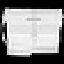

pred  Coat
target  Pullover


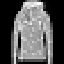

pred  T-shirt/top
target  Shirt


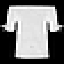

pred  Trouser
target  Trouser


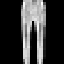

pred  Sandal
target  Sandal


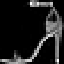

pred  Pullover
target  Pullover


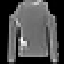

pred  Bag
target  Sandal


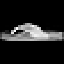

pred  Bag
target  Bag


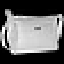

pred  Sneaker
target  Sneaker


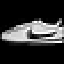

pred  Dress
target  Shirt


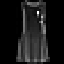

In [10]:
from IPython.display import display

for idx in np.random.randint(low=0,high=10000,size=(10)):
    class_names = train_ds.ds.classes
    pred = F.softmax(model(train_ds[idx][0].unsqueeze(0)),dim=1).argmax().item()
    target = train_ds[idx][1]
    print("pred ",class_names[pred])
    print("target ",class_names[target])
    display(train_ds.ds[idx][0].resize((64,64)))

In [11]:

preds,targets = [],[]
# First 1000 were training data
for idx in np.random.randint(low=1000,high=10000,size=(1000)):
    class_names = train_ds.ds.classes
    pred = F.softmax(model(train_ds[idx][0].unsqueeze(0)),dim=1).argmax().item()
    target = train_ds[idx][1]
    preds.append(pred)
    targets.append(target)

In [12]:
preds,targets=np.array(preds),np.array(targets)

In [13]:
print("accuracy after training on 1000 examples:")
print( (preds == targets).sum() / len(preds) )

accuracy after training on 1000 examples:
0.74


In [14]:
import pandas as pd
print("accuracy of null model (predicting most abundant class):")
pd.Series(targets).value_counts().max() / len(targets)

accuracy of null model (predicting most abundant class):


0.114

In [15]:
from sklearn.manifold import MDS
mds = MDS(n_components=2)

In [16]:
preds,targets,nn_embeds = [],[],[]
for idx in np.random.randint(low=1000,high=10000,size=(1000)):
    class_names = train_ds.ds.classes
    pred = F.softmax(model(train_ds[idx][0].unsqueeze(0)),dim=1).argmax().item()
    target = train_ds[idx][1]
    nn_embed = model.to_embedding(train_ds[idx][0].unsqueeze(0))[0]
    preds.append(pred)
    targets.append(target)
    nn_embeds.append(nn_embed.detach().numpy())


In [17]:
nn_embeds = np.vstack(nn_embeds)
print(nn_embeds.shape)

(1000, 196)


In [18]:
mds_embeds = mds.fit_transform(nn_embeds)

In [19]:
mds_embeds.shape

(1000, 2)

In [20]:
from matplotlib import pyplot as plt

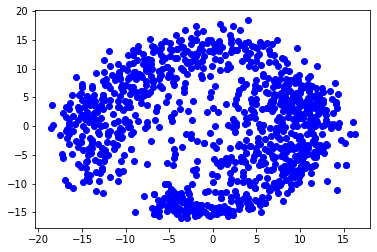

In [21]:
plt.plot(mds_embeds[:,0],mds_embeds[:,1],"bo")

In [22]:
import seaborn as sns

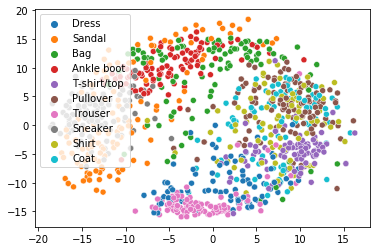

In [23]:
sns.scatterplot(x=mds_embeds[:,0],y=mds_embeds[:,1],hue=[class_names[tar] for tar in targets])

In [24]:
mds3_embeds = MDS(n_components=3).fit_transform(nn_embeds)

In [25]:
from mpl_toolkits.mplot3d import Axes3D

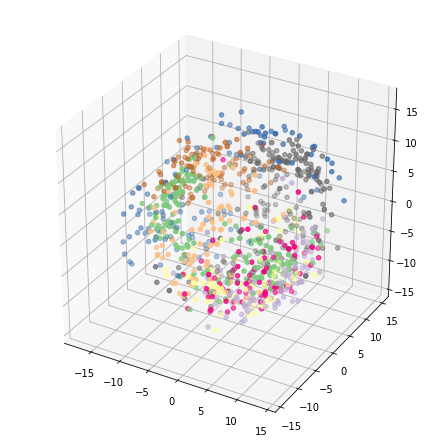

In [26]:
fig = plt.figure(figsize=(6,6))
Axes3D(fig).scatter(xs=mds3_embeds[:,0],ys=mds3_embeds[:,1],
                    zs=mds3_embeds[:,2],c=[tar for tar in targets],
                    cmap="Accent",
                   )

# Triplett SNN

In [27]:
ds = datasets.FashionMNIST("./data",download=True,)

In [28]:
xs = ds.data.numpy()
ys = ds.targets.numpy()

In [29]:
xs.shape,ys.shape

((60000, 28, 28), (60000,))

In [30]:
def generate_triplets(dataset, label, sample_per_class=10,num_classes=10,):
    x, y = None, None
    for i in range(num_classes):
        pos_indices = np.argwhere(label == i)[:,0]
        neg_indices = np.argwhere(label != i)[:,0]

        choice_anchor = np.random.choice(pos_indices.shape[0], sample_per_class, replace=False)
        choice_anchor = pos_indices[choice_anchor]

        choice_pos = np.random.choice(pos_indices.shape[0], sample_per_class, replace=False)
        choice_pos = pos_indices[choice_pos]

        choice_neg = np.random.choice(neg_indices.shape[0], sample_per_class, replace=False)
        choice_neg = neg_indices[choice_neg]

        sub_x_anc = dataset[choice_anchor]

        sub_x_pos = dataset[choice_pos]

        sub_x_neg = dataset[choice_neg]

        
        if(x is None):
            x = [(sub_x_anc), (sub_x_pos), (sub_x_neg)]
            y = [label[choice_anchor], label[choice_pos], label[choice_neg]]
        else:
            x[0] = np.vstack((x[0], (sub_x_anc)))
            x[1] = np.vstack((x[1], (sub_x_pos)))
            x[2] = np.vstack((x[2], (sub_x_neg)))

            y[0] = np.hstack((y[0].flatten(), label[choice_anchor].flatten()))
            y[1] = np.hstack((y[1].flatten(), label[choice_pos].flatten()))
            y[2] = np.hstack((y[2].flatten(), label[choice_neg].flatten()))
    
    return x, y

In [31]:
train_x, train_y = generate_triplets(xs,ys)

In [32]:
def visualize_data(data, n):
    n = min(len(data[0]), n)
    random_choices = np.random.choice(len(data[0]),n, replace=False)
    fig, ax = plt.subplots(n, 3,figsize=(10,40))
    anc, pos, neg = data
    for i,ch in enumerate(random_choices):
        ax[i, 0].imshow(np.squeeze(anc[ch] ))
        ax[i, 1].imshow(np.squeeze(pos[ch] ))
        ax[i, 2].imshow(np.squeeze(neg[ch] ))


        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
        ax[i, 2].set_axis_off()

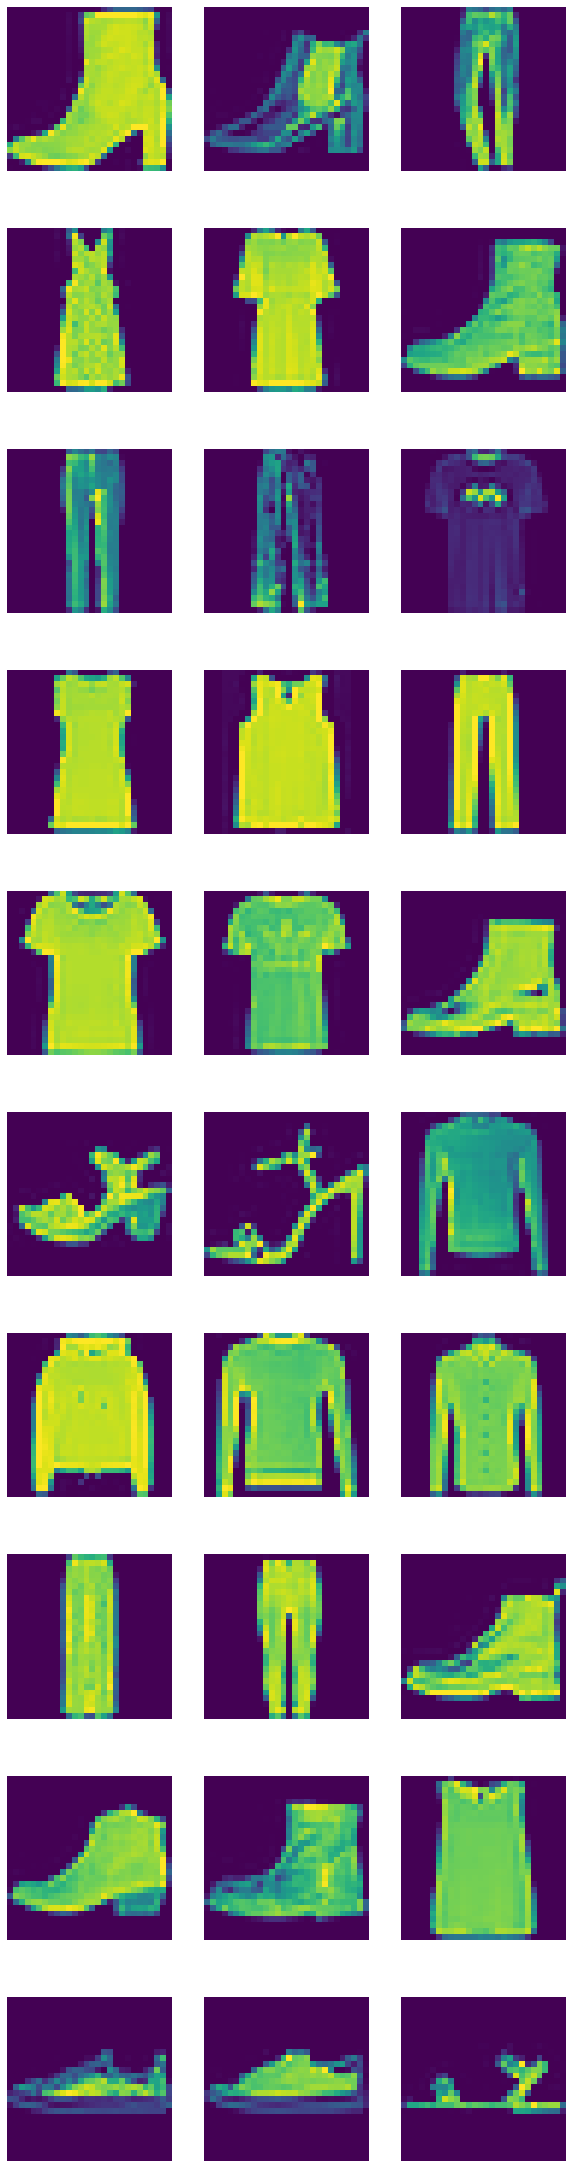

In [33]:
visualize_data(train_x,10)

In [34]:
class TripleData(Dataset):

    def __init__(self):
        self.x = datasets.FashionMNIST("./data",download=True,).data.numpy()
        self.y = datasets.FashionMNIST("./data",).targets.numpy()
        
    def __len__(self):
        return 1000 #len(self.ds) # TODO: remove patch for quicker train!
        
    def __getitem__(self,idx):
        return generate_triplets(self.x,self.y)


In [35]:
t_train_dl = DataLoader(dataset=TripleData(),batch_size=1,shuffle=True,num_workers=1,)

In [36]:

class TripleNet(pl.LightningModule):   
    def __init__(self):
        super(TripleNet, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(4 * 7 * 7, 3)
        )

    def forward(self, x):
        x = self.to_embedding(x)
        x = self.linear_layers(x)
        return x
    
    def to_embedding(self,x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        return x
    
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def get_loss_func(self):
        return torch.nn.CrossEntropyLoss()
    
    def triplet_loss(self,anchor,positive,negative):
        positive_distance = (anchor - positive)**2
        negative_distance = (anchor - negative)**2
        
        positive_distance = positive_distance.sum(axis=-1)
        negative_distance = negative_distance.sum(axis=-1)
        
        loss = positive_distance - negative_distance
        loss_maxplus = torch.max(torch.zeros(loss.shape),1+loss)
        #return torch.mean(loss_maxplus)
        return torch.mean(loss_maxplus)
    
    def training_step(self, train_batch, batch_idx):
        shape = (100,1,28,28)
        xs,ys = train_batch
        image_anchor,image_positive,image_negative = xs
        
        image_anchor,image_positive,image_negative = (
            image_anchor.reshape(shape),image_positive.reshape(shape),image_negative.reshape(shape))
        
        outputs_anchor = self(image_anchor/255.)
        outputs_positive = self(image_positive/255.)
        outputs_negative = self(image_negative/255.)
        #xs = xs.reshape(shape)
        
        
        return self.triplet_loss(outputs_anchor,outputs_positive,outputs_negative)
        #x, y = train_batch
        #y_pred = self(x)
        #loss = self.get_loss_func()(y_pred,y)
        #self.log("train_loss", loss)
        #return loss
    
    def validation_step(self, val_batch, batch_idx):
        return self.triplet_loss(val_batch)
        #x, y = val_batch
        #y_pred = self(x)
        #loss = self.get_loss_func()(y_pred,y)
        #self.log("train_loss", loss)
        #return loss

In [37]:
t_model = TripleNet()

In [38]:
t_trainer = pl.Trainer(max_epochs=10)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/jan/miniconda3/envs/ml373/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1580: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  "GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`."


In [39]:
t_trainer.fit(model=t_model,train_dataloaders=t_train_dl,)

/home/jan/miniconda3/envs/ml373/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:118: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")

  | Name          | Type       | Params
---------------------------------------------
0 | cnn_layers    | Sequential | 204   
1 | linear_layers | Sequential | 591   
---------------------------------------------
795       Trainable params
0         Non-trainable params
795       Total params
0.003     Total estimated model params size (MB)
/home/jan/miniconda3/envs/ml373/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` in

In [40]:
targets,nn_embeds = [],[]
for idx in np.random.randint(low=1000,high=10000,size=(1000)):
    class_names = train_ds.ds.classes
    target = train_ds[idx][1]
    nn_embed = t_model(train_ds[idx][0].unsqueeze(0))[0]
    targets.append(target)
    nn_embeds.append(nn_embed.detach().numpy())

This here is the main result. The triplet loss managed to resolve many of the categories well from another.
It is very sensible that e.g. Trousers (red) are well separated from the other classes, while
there is large confusion (see top left cluster) between Shirts, Pullovers and Coats which are optically very similar.

Taking the small amount of training data and low resolution of the input images into account this seems like a fair result.

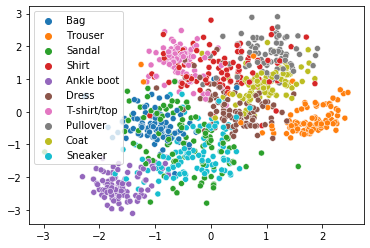

In [41]:
mds_embeds = MDS(n_components=2).fit_transform(nn_embeds)
sns.scatterplot(x=mds_embeds[:,0],y=mds_embeds[:,1],hue=[class_names[tar] for tar in targets])

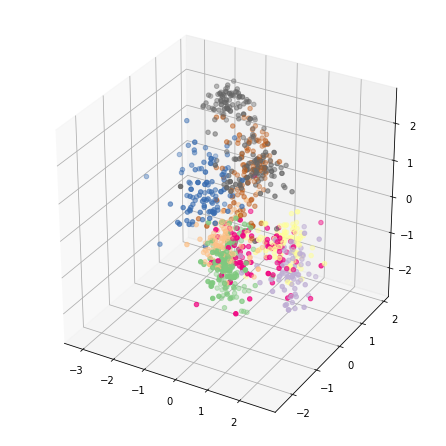

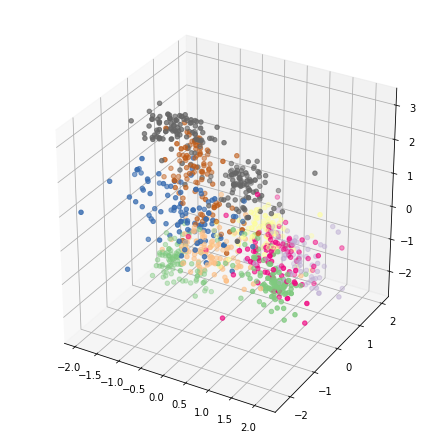

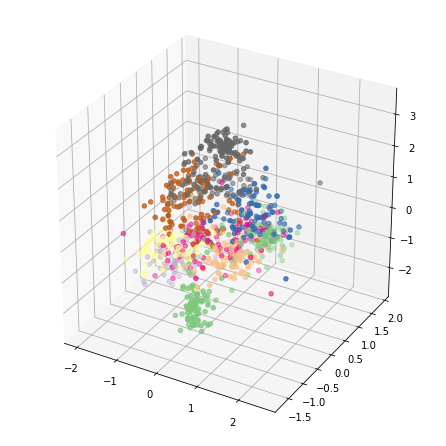

In [42]:
for _ in range(3):
    mds3_embeds = MDS(n_components=3).fit_transform(nn_embeds)
    fig = plt.figure(figsize=(6,6))
    Axes3D(fig).scatter(xs=mds3_embeds[:,0],ys=mds3_embeds[:,1],zs=mds3_embeds[:,2],c=[tar for tar in targets],
                       cmap="Accent")
    plt.show()

In [48]:
nn_embeds = np.vstack(nn_embeds)

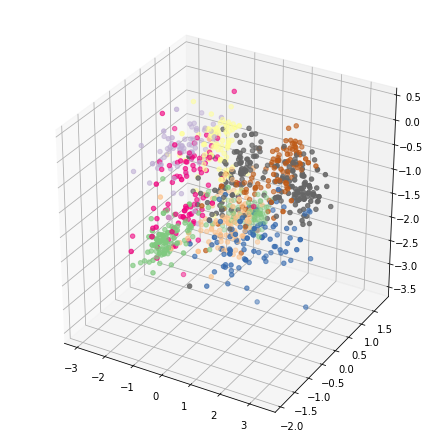

In [49]:
fig = plt.figure(figsize=(6,6))
Axes3D(fig).scatter(xs=nn_embeds[:,0],ys=nn_embeds[:,1],zs=nn_embeds[:,2],c=[tar for tar in targets],
                   cmap="Accent")
plt.show()